In [1]:
#yayyy - redes convolucionais
#vamos usar o MNIST
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\arthu\AppData\Local\Temp\ipykernel_4184\1192155045.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# convertendo as imagens do mnist pra tensores 4d (# de imagens, h,w,color)
transform = transforms.ToTensor()

In [3]:
#pegar os dados de treino
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
#criando um batch pras imagens
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
#definido o modelo (abstração)
conv1 = nn.Conv2d(1, 6, 3, 1) 
#camada de 2 dimensões, com:
# 1 imagem de entrada
# 6 saídas
# kernel 3x3
# stride de 1
conv2 = nn.Conv2d(6, 16, 3, 1) 

In [8]:
#pegando 1 imagem pra testar
for i, (x_train, y_train) in enumerate(train_data):
    break

x_train.shape
#uma imagem de 28x28

torch.Size([1, 28, 28])

In [9]:
x = x_train.view(1,1,28,28)

In [10]:
#fazendo a primeira convolução
x = F.relu(conv1(x))

In [11]:
x.shape
# 1 entrada
# 6 saídas, que no caso são filtros
# 26x26 virou o tamanho da imagem, pq informações foram cortadas por serem inuteis

torch.Size([1, 6, 26, 26])

In [12]:
#faznedo um pooling
x = F.max_pool2d(x,2,2) #kernel 2x2 stride 2

In [13]:
x.shape
# 1 entrada
# 6 saídas, que no caso são filtros
# 13x13 porque meu pooling reduziu a informação em 2

torch.Size([1, 6, 13, 13])

In [14]:
#segunda convolução
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [15]:
#pooling
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

In [17]:
#fazendo o modelo
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        #Fully Connected Layer
        #tamanho do negócio que gerou ali no final
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)

        #re-view pra deixar de um jeito bom pra FC
        x = x.view(-1,16*5*5)

        #camadas FC
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [18]:
#instanciando o modelo
torch.manual_seed(41)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #quando menor lr, mais tempo demora

In [21]:
#treinar!!!!!
import time
start_time = time.time()

#variáveis pra cuidar da precisão da rede
epochs = 5 #de 5 em 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#loops pras epochs
for i in range(epochs):
    trn_correct = 0
    tst_correct = 0
    #treino
    for b, (x_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr

        #atualizar os parâmetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #printar uns resultados
        if (b%600 == 0):
            print(f'Epoch: {i}  Batch: {b}  Loss:{loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_correct)

    #teste
    with torch.no_grad(): #sem backpropagation
        for b, (x_test, y_test) in enumerate(test_loader):
            y_val = model(x_test)
            predicted = torch.max(y_val.data,1)[1]
            tst_correct += (predicted == y_train).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)

current_time = time.time()
total_time = current_time - start_time
print(f'total_time: {total_time/60} minutos')

Epoch: 0  Batch: 600  Loss:0.012505684979259968
Epoch: 0  Batch: 1200  Loss:0.057655591517686844
Epoch: 0  Batch: 1800  Loss:0.015625834465026855
Epoch: 0  Batch: 2400  Loss:0.1324503868818283
Epoch: 0  Batch: 3000  Loss:0.003808070672675967
Epoch: 0  Batch: 3600  Loss:0.010613595135509968
Epoch: 0  Batch: 4200  Loss:0.23633775115013123
Epoch: 0  Batch: 4800  Loss:0.007425201125442982
Epoch: 0  Batch: 5400  Loss:0.017431829124689102
Epoch: 0  Batch: 6000  Loss:0.009718138724565506
Epoch: 1  Batch: 600  Loss:0.010102563537657261
Epoch: 1  Batch: 1200  Loss:0.013631263747811317
Epoch: 1  Batch: 1800  Loss:0.026421785354614258
Epoch: 1  Batch: 2400  Loss:0.2190006673336029
Epoch: 1  Batch: 3000  Loss:0.05793539434671402
Epoch: 1  Batch: 3600  Loss:0.000245834409724921
Epoch: 1  Batch: 4200  Loss:0.00030721232178620994
Epoch: 1  Batch: 4800  Loss:0.0005000090459361672
Epoch: 1  Batch: 5400  Loss:0.006974146701395512
Epoch: 1  Batch: 6000  Loss:0.0005777432816103101
Epoch: 2  Batch: 600  Lo

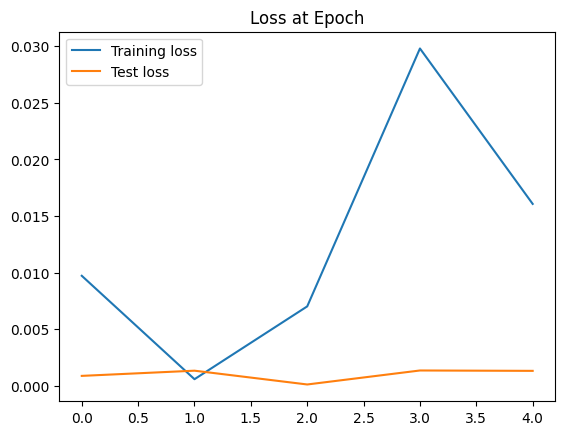

In [22]:
#gráficos!
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.title("Loss at Epoch")
plt.legend()

In [23]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [24]:
with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load_everything:
        y_val = model(x_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
    
print(f"certos: {correct.item()}!!!")
print(f"precisão: {correct.item()/len(test_data)}!!!")

certos: 9875!!!
precisão: 0.9875!!!


In [41]:
# pegando uma imagem
img = test_data[413][0].reshape(28,28) #nos dá um tensor com dados de uma imagem

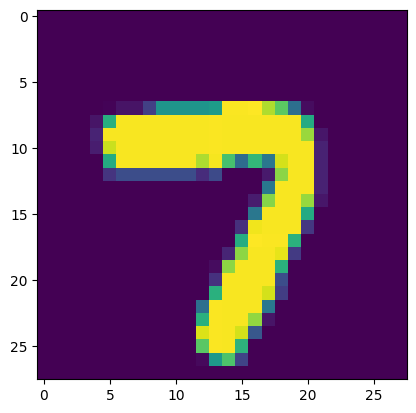

In [42]:
#mostrando
plt.imshow(img)

In [43]:
#rodar
model.eval()
with torch.no_grad():
    new_prediction = model(img.view(1,1,28,28))

new_prediction.argmax()

tensor(7)